In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist

<br>

## Preprocessing of image

In [3]:
import cv2
import base64

In [4]:
# load the  base64 img from file

def load_base64_img():
    with open('img.txt') as f:
        return f.read()

In [5]:
# convert the base64 image/ image path --> transparent image to white background ---> to array using cv2

def get_cv2_image_from_base64_string(b64str, img_path):
    if img_path:
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    else:
        encoded_data = b64str.split(',')[1]
        nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED) # load the image with alpha channel
        
    
    ## transparent to white bg 
    alpha_channel = img[: ,: , 3]
    _, mask = cv2.threshold(alpha_channel, 254, 255, cv2.THRESH_BINARY) # binarize mask
    color = img[: ,: ,: 3]
    new_img = cv2.bitwise_not(cv2.bitwise_not(color, mask = mask))
    return new_img

In [15]:
# resizing the image into 28x28 pixels

def get_img_reshape_by_cv2(img_data):
    image = img_data
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY) # convert to gray
    ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    preprocessed_digits = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)

        # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
        roi = cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=1)

        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit = thresh[y:y+h, x:x+w]

        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (100,100))
        resized_digit = cv2.resize(resized_digit, (50,50))
        resized_digit = cv2.resize(resized_digit, (40,40))
        resized_digit = cv2.resize(resized_digit, (25,25))
        resized_digit = cv2.resize(resized_digit, (18,18)) ##### <------

        # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)

        # Adding the preprocessed digit to the list of preprocessed digits
        preprocessed_digits.append(padded_digit)

    # plt.imshow(padded_digit, cmap="gray")
    # plt.show()
    
    # print(preprocessed_digits)
    inp = np.array(preprocessed_digits)
    return inp

<br>

## Preprocessing of Dataset

In [197]:
# define the path of dataset and cropped img

path_to_data = "./dataset/"
path_to_cropped = "./dataset/cropped/"

In [198]:
import shutil, os

if os.path.exists(path_to_cropped):
    shutil.rmtree(path_to_cropped)

In [199]:
# get all the digits image dir from the dataset into the list

import os
img_dirs = []

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['./dataset/0',
 './dataset/1',
 './dataset/2',
 './dataset/4',
 './dataset/5',
 './dataset/6',
 './dataset/7',
 './dataset/8',
 './dataset/9']

In [200]:
# check whether the cropped img folder is present or not

if os.path.exists(path_to_cropped):
    shutil.rmtree(path_to_cropped)
os.mkdir(path_to_cropped)

In [201]:
# cropping the dataset digit images

crop_img_dirs = []
digit_dict = {}

for img_dir in img_dirs:
    count = 1    
    digit = (img_dir.split('/')[-1])
    digit_dict[digit]=[]
    
    for entry in os.scandir(img_dir):
        url = entry.path
        
        img_b64_transp = get_cv2_image_from_base64_string(None, url)
        # print(img_b64_transp)
        
        reshape_img = get_img_reshape_by_cv2(img_b64_transp)
        crop_digit = reshape_img
        
        # print(crop_digit[0])
        # plt.imshow(crop_digit[0])
        if crop_digit is not None:
            crop_img_folder = path_to_cropped + digit
            if not os.path.exists(crop_img_folder):
                print("Generating cropped digit_img folder: ", crop_img_folder)
                os.mkdir(crop_img_folder)
                crop_img_dirs.append(crop_img_folder)
            
            crop_file_name = digit + "_" + str(count) + ".png"
            crop_file_path = crop_img_folder + "/" + crop_file_name
            
            
            cv2.imwrite(crop_file_path, crop_digit[0])
            digit_dict[digit].append(crop_file_path)
            count+=1
print("\nSuccesfully Completed! 😊")

Generating cropped digit_img folder:  ./dataset/cropped/0
Generating cropped digit_img folder:  ./dataset/cropped/1
Generating cropped digit_img folder:  ./dataset/cropped/2
Generating cropped digit_img folder:  ./dataset/cropped/4
Generating cropped digit_img folder:  ./dataset/cropped/5
Generating cropped digit_img folder:  ./dataset/cropped/6
Generating cropped digit_img folder:  ./dataset/cropped/7
Generating cropped digit_img folder:  ./dataset/cropped/8
Generating cropped digit_img folder:  ./dataset/cropped/9

Succesfully Completed! 😊


In [202]:
# appending the file path of each of the digit image in the dictinary

digit_dict = {}

for img_dir in crop_img_dirs:
    digit = img_dir.split("/")[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    digit_dict[digit] = file_list

digit_dict['0'][:5]

['./dataset/cropped/0\\0_1.png',
 './dataset/cropped/0\\0_10.png',
 './dataset/cropped/0\\0_11.png',
 './dataset/cropped/0\\0_12.png',
 './dataset/cropped/0\\0_13.png']

<br>

## Test, train split

In [366]:
X, y = [], []

for digit, digit_img_path in digit_dict.items():
    for training_img in digit_img_path:
        img = cv2.imread(training_img)
        
        if img is None:
            continue
            
        img=img/225.0
        
        img_rshp = img.reshape(28, 28, 3)    # reshape img into 1D
        X.append(img)
        y.append(digit)

In [367]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [370]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [369]:
X[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [363]:
len(X), len(X[0])

(193, 28)

In [364]:
X = np.array(X).reshape(len(X[0]), len(X)).astype(float)
X.shape

ValueError: cannot reshape array of size 453936 into shape (28,193)

In [238]:
X[0].shape

(784, 3)

In [239]:
X.shape

(193, 784, 3)

In [244]:
len(y)

193

In [259]:
y = np.array(y)

<br>

## Build the model

In [260]:
model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation="sigmoid")
])

In [261]:
model.compile(optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy']
)

In [262]:
model.fit(X, y, epochs=5)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\Debjeet\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Debjeet\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Debjeet\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Debjeet\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Debjeet\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Debjeet\AppData\Roaming\Python\Python310\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 28, 28), found shape=(None, 784, 3)


In [24]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 679us/step - loss: 0.0766 - accuracy: 0.9749


[0.07661169767379761, 0.9749000072479248]

<br>

## Lets, now check how well our model performs by giving an actuall image as input 

In [371]:
n_img = get_cv2_image_from_base64_string(load_base64_img(), None)
n_img.shape ## returns x, y, rbg

(600, 600, 3)

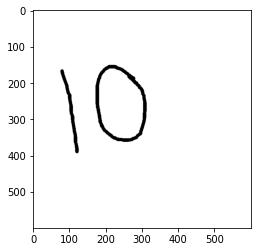

In [372]:
plt.imshow(n_img)

In [373]:
crop_img = get_img_reshape_by_cv2(n_img)

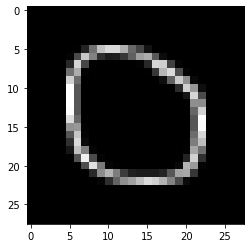

In [386]:
plt.gray()
plt.imshow(crop_img[1])

In [387]:
crop_img[1].shape

(28, 28)

In [388]:
pred = model.predict(crop_img[1].reshape(1,28,28))

In [389]:
np.argmax(pred)

3